# ORIE 5257 Request for Quote
***Vishad Bhalodia, Jenny Jee, David Fitzpatrick, Harshavardhan Bapat, Ivan Kosyuk***

## Imports

In [1]:
import pandas as pd
import numpy as np
import sys, math, os, json, re, random
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from reticulum import AdaptiveBayesianReticulum
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from tqdm import tqdm

# jupyter magic to display plots directly in the notebook
%matplotlib inline

# use vector graphics format for nicer plots
%config Inline.Backend.figure_format = 'svg'

%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2

In [16]:
DATA = 'RfqData.xlsx'
sheets = pd.ExcelFile(DATA).sheet_names
training = pd.read_excel(DATA, sheet_name=sheets[0])
total_test = pd.read_excel(DATA, sheet_name=sheets[1])
competition = pd.read_excel(DATA, sheet_name=sheets[2])

### Partition Test data into OOS and Hidden

In [19]:
oos_test = total_test.loc[:800, :].copy()

In [17]:
hidden_test = total_test.loc[800:, :].copy().reset_index()
hidden_test_quotes = hidden_test.loc[:, 'QuotedPrice']
hidden_test_nextmp = hidden_test.loc[:, 'NextMidPrice']
hidden_test.at[:, 'QuotedPrice'] = np.nan
hidden_test = hidden_test.drop(columns=['index','Traded', 'NextMidPrice'])

## Analysis

In [21]:
data = training.copy()
data['quote_diff'] = data['QuotedPrice'] - data['MidPrice']
data['quote_diff_pct'] = data['quote_diff']/data['MidPrice']
data['next_mid_diff'] = data['NextMidPrice'] - data['MidPrice']
data['next_mid_diff_pct'] = data['next_mid_diff']/data['MidPrice']
data['log_notional'] = np.log(data['Notional'])

How much does the market move when the counterparty trades?

In [22]:
for n in np.arange(4):
    notional = data.loc[data['Counterparty']=='Ctpy_'+str(n),'Notional'].abs().mean()
    movement = data.loc[data['Counterparty']=='Ctpy_'+str(n),'next_mid_diff'].abs().mean()
    print('counterparty'+str(n))
    print('notional:                              ',round(notional,2))
    print('movement from current mid to next mid: ',round(movement,4))
    print('movement/notional * scaling:           ',round((movement/notional)*10**8,2))

counterparty0
notional:                               1383446.91
movement from current mid to next mid:  0.0651
movement/notional * scaling:            4.71
counterparty1
notional:                               1616066.13
movement from current mid to next mid:  0.1039
movement/notional * scaling:            6.43
counterparty2
notional:                               1284649.57
movement from current mid to next mid:  0.0693
movement/notional * scaling:            5.39
counterparty3
notional:                               1376676.22
movement from current mid to next mid:  0.0998
movement/notional * scaling:            7.25


In [23]:
# small price movement for Counterparty 0 and 2
# big price movement for Counterparty 1 and 3

In [24]:
ctpy0 = data[data['Counterparty'] == 'Ctpy_0']
ctpy1 = data[data['Counterparty'] == 'Ctpy_1']
ctpy2 = data[data['Counterparty'] == 'Ctpy_2']
ctpy3 = data[data['Counterparty'] == 'Ctpy_3']

Counterparty  0


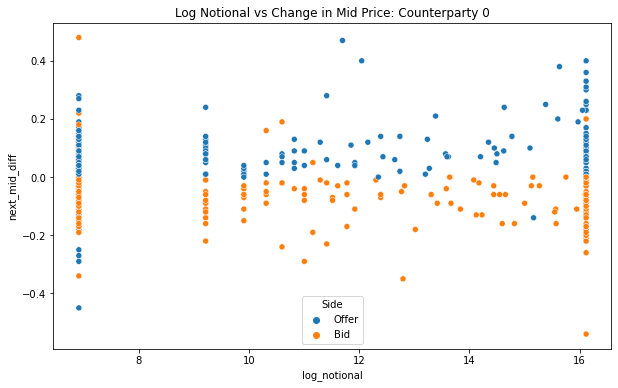

Counterparty  1


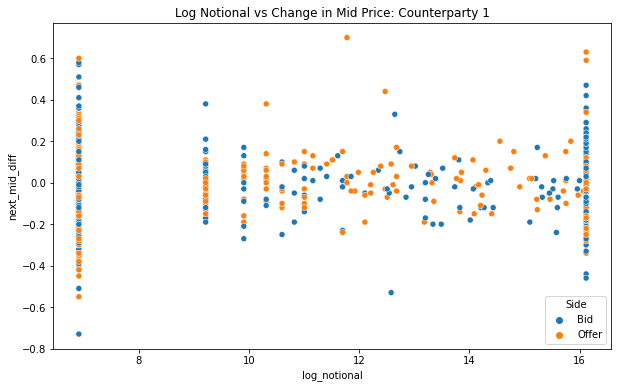

Counterparty  2


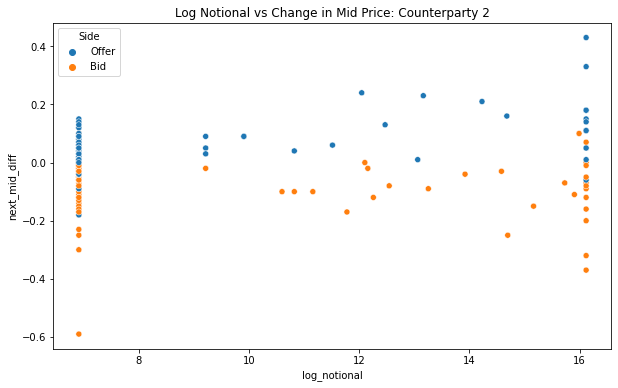

Counterparty  3


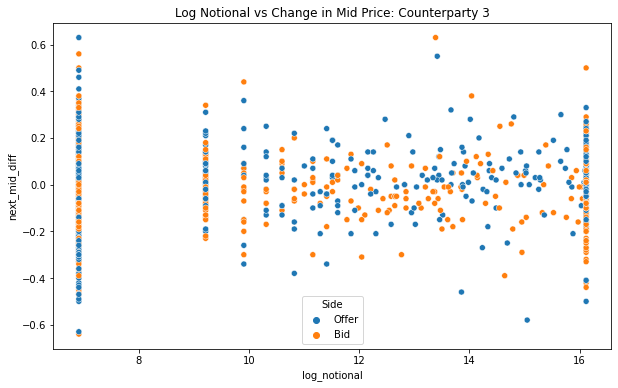

In [25]:
counterparties = [ctpy0, ctpy1, ctpy2, ctpy3]
for i, df in enumerate(counterparties):
    print('Counterparty ', i)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='log_notional',y='next_mid_diff', data=df, hue='Side')
    plt.title("Log Notional vs Change in Mid Price: Counterparty " + str(i))
    plt.savefig("Counterparty"+str(i)+".png")
    plt.show()

In [27]:
# Ctpy 0 and 2 are almost always on the right side of the trade as per price movement
# Conclusions:
# Ctpy 0 and 2 are informed traders (Sharks/Hedge Funds)
# Ctpy 1 and 3 are uninformed traders

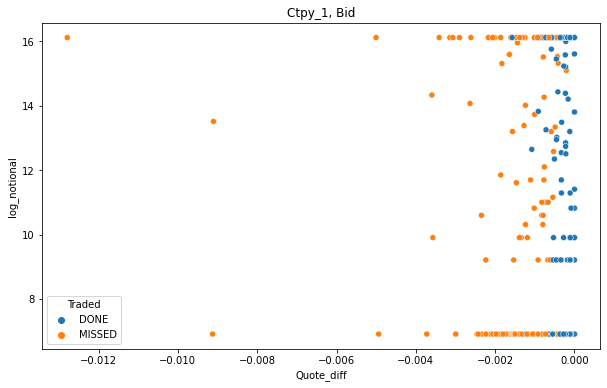

In [30]:
df_analysis = training.query("Counterparty == 'Ctpy_1'").copy()
df_analysis['Quote_diff'] = df_analysis['QuotedPrice']/df_analysis['MidPrice'] - 1
df_analysis['log_notional'] = np.log(df_analysis['Notional'])
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quote_diff',y='log_notional', data=df_analysis[df_analysis['Side'] == 'Bid'], hue='Traded')
plt.title('Ctpy_1, Bid')
plt.show()

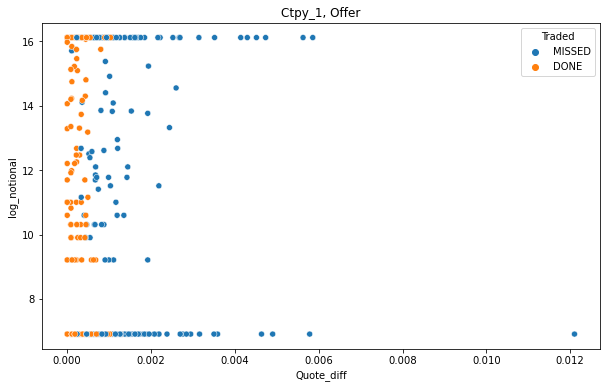

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quote_diff',y='log_notional', data=df_analysis[df_analysis['Side'] == 'Offer'], hue='Traded')
plt.title('Ctpy_1, Offer')
plt.show()

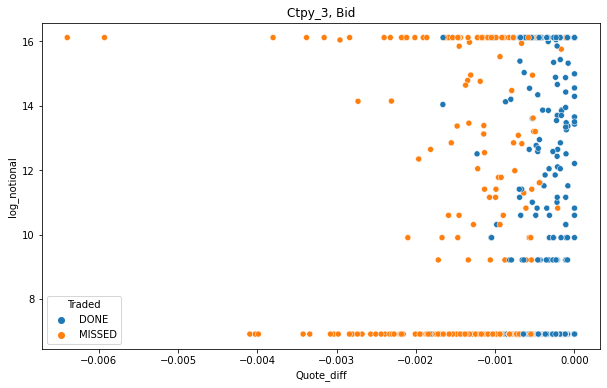

In [33]:
df_analysis = training.query("Counterparty == 'Ctpy_3'").copy()
df_analysis['Quote_diff'] = df_analysis['QuotedPrice']/df_analysis['MidPrice'] - 1
df_analysis['log_notional'] = np.log(df_analysis['Notional'])
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quote_diff',y='log_notional', data=df_analysis[df_analysis['Side'] == 'Bid'], hue='Traded')
plt.title('Ctpy_3, Bid')
plt.show()

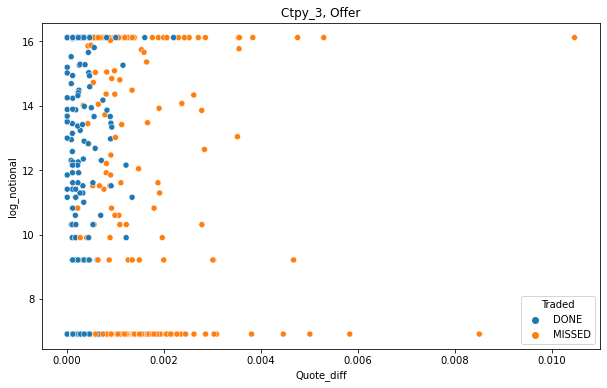

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quote_diff',y='log_notional', data=df_analysis[df_analysis['Side'] == 'Offer'], hue='Traded')
plt.title('Ctpy_3, Offer')
plt.show()

In [35]:
# For Ctpy 1 and 3, we do not have a good estimate for where the price will move next.
# Quotes that have went through have been close to the current mid price.

**Conclusions from Analysis:**<br>
1. Counterparties 0 and 2 are informed traders. Price typically moves in the favor of the counterparty after the trade. This means we have some information as to where the price will move, maybe can use this to generate forecast of next price.
2. Counterparties 1 and 3 are uninformed traders. Price moves fairly randomly and widely after the trade. This means we cannot make a reasonable forecast for next price. Might be prudent to use current price as base forecast for next price.
3. Quotes that have gone through for Counterparties 1 and 3 are generally very close to the current price. Our model should be incorporating this. 

## Training Models

In [36]:
target_mapping = {'MISSED': 0, 'DONE': 1}

In [37]:
def add_features(df):
    df['Notional_cuts'] = pd.cut(df['Notional'], [0, 100000, 1000000, 10000000, 50000000], labels=[0, 1, 2, 3], include_lowest=True, right=True)
    df['Traded'] = df['Traded'].map(target_mapping)
    
    return df

### Trade Classification

We use the Adaptive Bayesian Reticulum to train a classifier to identify probability of a trade being won or lost

In [38]:
def add_features_classifier(df):
    df['quote_diff'] = (df['QuotedPrice'] - df['MidPrice'])
    df['Traded'] = df['Traded'].map(target_mapping)
    # df['Competitors'] = df['Competitors'].apply(lambda x: str(x))
    df['Notional_cuts'] = pd.cut(df['Notional'], [0, 100000, 1000000, 10000000, 50000000], labels=[0, 1, 2, 3], include_lowest=True, right=True)
    
    cols = ['Side']
    one_hot_encode = pd.get_dummies(df[cols])
    df = df.join(one_hot_encode)
    
    cols_to_drop = ['Bond', 'Side', 'Counterparty', 'Time'] + ['Notional', 'QuotedPrice', 'MidPrice', 'NextMidPrice']
    
    return df.drop(columns=cols_to_drop)

In [39]:
def prep_data_classifier(train, test, y_value): # extract input and target
    X_train = train.drop(columns=[y_value]).values  
    y_train = train[[y_value]].values.ravel()
    
    X_test = test.drop(columns=[y_value]).values
    y_test = test[[y_value]].values.ravel()
    
    return X_train, y_train, X_test, y_test

In [40]:
training_classifier = add_features_classifier(training.copy())
test_classifier = add_features_classifier(oos_test.copy())

In [41]:
X_train_c, y_train_c, X_test_c, y_test_c = prep_data_classifier(training_classifier, test_classifier, 'Traded')

In [42]:
# train model
ABRmodel = AdaptiveBayesianReticulum(
    prior=(1, 1),
    pruning_factor=1.01,
    n_iter=100,
    learning_rate_init=0.05,
    n_gradient_descent_steps=1,
    initial_relative_stiffness=20)

t0 = dt.datetime.utcnow()
ABRmodel.fit(X_train_c, y_train_c, verbose=False)
t1 = dt.datetime.utcnow()

# print('Model:')
# print(ABRmodel)
print(f'Training took {t1-t0}')

# evaluate performance
log_loss_train = log_loss(y_train_c, ABRmodel.predict_proba(X_train_c))
log_loss_test = log_loss(y_test_c, ABRmodel.predict_proba(X_test_c))
accuracy_train = accuracy_score(y_train_c, ABRmodel.predict(X_train_c))
accuracy_test = accuracy_score(y_test_c, ABRmodel.predict(X_test_c))

info_train = f'Train: Log-loss = {log_loss_train}, accuracy = {100*accuracy_train:.4f} %'
info_test = f'Test: Log-loss = {log_loss_test}, accuracy = {100*accuracy_test:.4f} %'
print(f'Depth:  {ABRmodel.get_depth()}')
print(f'Leaves: {ABRmodel.get_n_leaves()}')
print(info_train)
print(info_test)
print(f'Feature importance: {ABRmodel.feature_importance()}')

Training took 0:00:00.587013
Depth:  11
Leaves: 55
Train: Log-loss = 0.40480641436849846, accuracy = 82.7200 %
Test: Log-loss = 0.4190594500814067, accuracy = 82.1473 %
Feature importance: [0.059857   0.74400727 0.0392287  0.0878419  0.06906514]


### MidPrice Prediction

We attempt to generate a prediction for the NextMidPrice as an input to our model for generating the best quote for a particular trade. <br>
Since the probability of resulting in a loss making quote increases are our forecast error increases, we calculate the empirical cdf of errors in our model training. 

In [44]:
def add_features_rf(df, nextmidp=True):
    df['Notional_cuts'] = pd.cut(df['Notional'], [0, 100000, 1000000, 10000000, 50000000], labels=[0, 1, 2, 3], include_lowest=True, right=True)
    
    if nextmidp:
        df['NextMidP'] = df['NextMidPrice']/df['MidPrice']
        df['Traded'] = df['Traded'].map(target_mapping)
    
    cols = ['Side']
    one_hot_encode = pd.get_dummies(df[cols])
    df = df.join(one_hot_encode)
    
    cols3 = ['Bond']
    one_hot_encode3 = pd.get_dummies(df[cols3])
    df = df.join(one_hot_encode3)
    
    cols_to_drop = ['Bond', 'Side', 'Time', 'QuotedPrice', 'Notional']
    
    if nextmidp:
        cols_to_drop = cols_to_drop + ['NextMidPrice', 'Traded']
    
    return df.drop(columns=cols_to_drop)

In [45]:
def random_forest_hyperparameters(X_train, y_train, X_test, y_test):
    estimators = np.arange(5, 51, 1)
    train_rmses = []
    test_rmses = []
    train_sign_errors = []
    test_sign_errors = []
    
    for e in tqdm(estimators):
        regressor, preds, metrics = random_forest(X_train, y_train, X_test, y_test, e)
        train_rmses.append(metrics[0])
        test_rmses.append(metrics[1])
        train_sign_errors.append(metrics[2])
        test_sign_errors.append(metrics[3])
        
    plt.plot(estimators, train_rmses)
    plt.title('Train RMSE')
    plt.show()
    plt.plot(estimators, test_rmses)
    plt.title('Test RMSE')
    plt.show()
    
    plt.plot(estimators, train_sign_errors, label='Train')
    plt.plot(estimators, test_sign_errors, label='Test')
    plt.title('Sign Errors')
    plt.legend()
    plt.show()
    
    return regressor, [train_rmses, test_rmses, train_sign_errors, test_sign_errors]

In [46]:
def random_forest(X_train, y_train, X_test, y_test, e):
    regressor = RandomForestRegressor(n_estimators=e, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    train_rmse = (np.sqrt(metrics.mean_squared_error(regressor.predict(X_train), y_train)))
    test_rmse = (np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    train_se = (np.sign(regressor.predict(X_train) -np.ones(len(X_train))) != np.sign(y_train - np.ones(len(X_train)))).sum()/len(X_train)
    test_se = (np.sign(y_pred - np.ones(len(y_pred))) != np.sign(y_test - np.ones(len(y_pred)))).sum()/len(y_test)
    return regressor, y_pred, [train_rmse, test_rmse, train_se, test_se]

In [47]:
def get_train_test(df_train, df_test):
    X_train = df_train.drop(columns=['NextMidP', 'MidPrice', 'Counterparty']).values
    y_train = df_train[['NextMidP']].values.ravel()
    X_test = df_test.drop(columns=['NextMidP', 'MidPrice', 'Counterparty']).values
    y_test = df_test[['NextMidP']].values.ravel()
    
    return X_train, y_train, X_test, y_test

In [56]:
counterparty_models = {}
counterparty_ecdfs = {}
counterparty_errors = {}

In [57]:
def random_forest_for_counterparty(training, test, counterparty):
    train = add_features_rf(training.query("Counterparty == @counterparty").copy())
    test = add_features_rf(test.query("Counterparty == @counterparty").copy())
    
    train_midp = train[['MidPrice']].values.ravel()
    
    X_train, y_train, X_test, y_test = get_train_test(train, test)
    
    reg, y_pred, error_metrics = random_forest(X_train, y_train, X_test, y_test, 40)
    print(counterparty)
    print("Train RMSE =", error_metrics[0])
    print("Test RMSE =", error_metrics[1])
    print("Train sign error =", error_metrics[2])
    print("Test sign error =", error_metrics[3])
    
    train_preds = reg.predict(X_train)
    next_midp_pred = train_preds * train_midp
    next_midp_true = y_train * train_midp
    errors = next_midp_pred - next_midp_true
    print('Train RMSE in $ =', np.sqrt(np.mean(np.power(errors, 2))))
    ecdf = ECDF(errors)
    
    counterparty_models[counterparty] = reg
    counterparty_ecdfs[counterparty] = ecdf
    counterparty_errors[counterparty] = errors
    
    #counterparty_models[counterparty] = {'model':reg, 'ecdf':ecdf}

In [58]:
def base_pred_errors_for_counterparty(training, counterparty):
    df = training.query("Counterparty == @counterparty").copy()
    train_midp = df[['MidPrice']].values.ravel()
    train_preds = train_midp
    next_midp_pred = train_midp
    next_midp_true = df[['NextMidPrice']].values.ravel()
    errors = next_midp_pred - next_midp_true
    print('RMSE in $ =', np.sqrt(np.mean(np.power(errors, 2))))
    ecdf = ECDF(errors)
    #plt.hist(errors, bins=50);
    
    counterparty_ecdfs[counterparty] = ecdf
    counterparty_errors[counterparty] = errors

Since we have some information on price movement for trades involving Counterparty 0 and 2, we can attempt to build a price prediction model for trades involving these two counterparties. We train a random forest model to obtain price predictions for trades that involve Counterparty 0 or 2.

In [59]:
random_forest_for_counterparty(training, oos_test, "Ctpy_0")

Ctpy_0
Train RMSE = 0.0006045980594882525
Test RMSE = 0.0006262259529050186
Train sign error = 0.08783783783783784
Test sign error = 0.12337662337662338
Train RMSE in $ = 0.06563054833502295


In [60]:
random_forest_for_counterparty(training, oos_test, "Ctpy_2")

Ctpy_2
Train RMSE = 0.0005465394985861825
Test RMSE = 0.0007677481576900589
Train sign error = 0.09829059829059829
Test sign error = 0.24390243902439024
Train RMSE in $ = 0.061621656194033474


Since we do not have any information that gives us conviction we can predict price movement for trades involving Counterparty 1 and 3, our forecast for NextMidPrice in these cases is taken as the current MidPrice. 

In [61]:
base_pred_errors_for_counterparty(training, "Ctpy_1")

RMSE in $ = 0.14059849171219221


In [62]:
base_pred_errors_for_counterparty(training, "Ctpy_3")

RMSE in $ = 0.13545845262265285


Below are the distribution of errors for our MidPrice forecasts for each counterparty

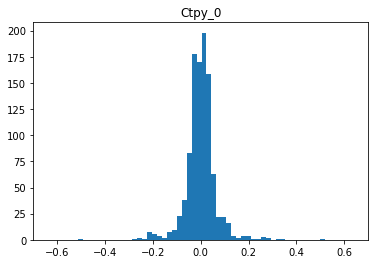

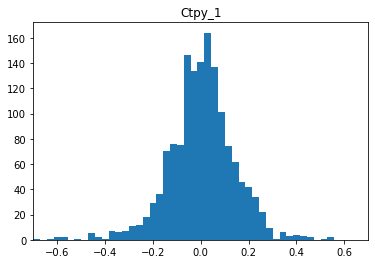

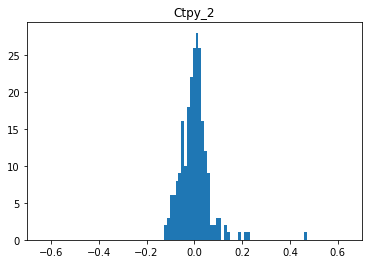

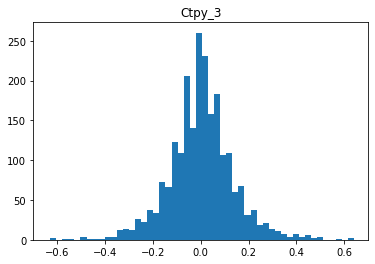

In [67]:
for ctpy in ['Ctpy_0', 'Ctpy_1', 'Ctpy_2', 'Ctpy_3']:
    plt.figure(figsize=(6, 4))
    plt.hist(counterparty_errors[ctpy], bins=50)
    plt.xlim((-0.7, 0.7))
    plt.title(ctpy)
    plt.show()

### Standard Deviation in Price movement by Bond and Notional

In order to understand what is a feasible starting set of quotes to analyse for our model, we observe how prices move by Bond and Notional. We observe each bond has a significantly different range of price movement, and in most cases this increases as size of notional increases. We will use this standard deviation to set a bound for the range of values we analyse in cases where the current mid price does not provide an appropriate lower/upper bound.

In [69]:
def get_bond_stdevs(training):
    trial_training = add_features(training.copy(deep=True))
    trial_training['MidPrice_diff'] = trial_training['NextMidPrice'] - trial_training['MidPrice']
    bond_stds = trial_training.groupby(['Bond', 'Notional_cuts'])['MidPrice_diff'].std().reset_index()
    return bond_stds

In [70]:
bond_stds = get_bond_stdevs(training)

### Best Quote Model

A detailed explanation of the process to select best quote is outlined in our note.

In [72]:
def get_bond(trade):
    if trade.loc['Bond_Bond_0'] == 1:
        return 'Bond_0'
    if trade.loc['Bond_Bond_1'] == 1:
        return 'Bond_1'
    if trade.loc['Bond_Bond_2'] == 1:
        return 'Bond_2'

In [73]:
def get_side(trade):
    if trade.loc['Side_Bid'] == 1:
        return 'Bid'
    if trade.loc['Side_Offer'] == 1:
        return 'Offer'

In [74]:
def delta_range(curr_mid, next_mid_pred, sd, notional, side):
    higher = next_mid_pred > curr_mid
    equal = next_mid_pred == curr_mid
    if side == "Offer":
        if higher:
            return np.arange(next_mid_pred, next_mid_pred + sd+0.001, 0.01)
        elif equal:
            return np.arange(next_mid_pred, next_mid_pred + sd+0.001, 0.01)
        else:
            return np.arange(curr_mid, next_mid_pred+0.001, 0.01)
        
    if side == "Bid":
        if higher:
            return np.arange(curr_mid, next_mid_pred)
        elif equal:
            return np.arange(next_mid_pred - sd, next_mid_pred+0.001, 0.01)
        else:
            return np.arange(next_mid_pred - sd, next_mid_pred+0.001, 0.01)

In [75]:
def profit_scenario(side):
    if side == "Offer":
        print('Profit if Quote Price is above Next Mid Price')
    elif side == "Bid":
        print('Profit if Quote Price is below Next Mid Price')

In [77]:
def get_quote_price(trade, identifier, counterparty_lambdas, print_=False):
    midp = np.round(trade['MidPrice'], 2)
    #next_midp_true = np.round(midp*trade['NextMidP'], 2)
    trade_rf = trade.drop(index=['MidPrice']).values.reshape(1, -1)
    
    trade_bond = get_bond(trade)
    trade_notional = int(trade['Notional_cuts'])
    trade_side = get_side(trade)
    
    if print_:
        print(f"Trade is for {trade_side} side")
        profit_scenario(trade_side)
    
    if identifier in counterparty_models.keys():
        if print_:
            print('Using model to generate midprice forecast')
        pred = counterparty_models[identifier].predict(trade_rf)[0]
        next_midp_pred = np.round(midp*pred, 2)
    else:
        if print_:
            print('Current midprice is estimate of next midprice')
        next_midp_pred = np.round(midp, 2)
    
    if print_:
        print(f"Current mid price is: {midp}")
        print(f"Predicted next mid price is: {next_midp_pred}") #and actual next mid price is: {next_midp_true}")
    
    
        
    sd = bond_stds.query("Bond == @trade_bond and Notional_cuts == @trade_notional").iloc[0]['MidPrice_diff']
    
    deltas = delta_range(midp, next_midp_pred, sd, trade_notional, trade_side)
    
    deltas_df = pd.DataFrame(deltas, columns=['Quotes'])
    deltas_df['Competitors'] = trade['Competitors']
    deltas_df['Notional_cuts'] = trade['Notional_cuts']
    deltas_df['Side_Bid'] = trade['Side_Bid']
    deltas_df['Side_Offer'] = trade['Side_Offer']
    deltas_df['quote_diff'] = (deltas_df['Quotes'] - midp)
    
    if trade_side == 'Offer':
        deltas_df['p_neg'] = counterparty_ecdfs[identifier](next_midp_pred - deltas_df['Quotes'])
    if trade_side == 'Bid':
        deltas_df['p_neg'] = 1 - counterparty_ecdfs[identifier](next_midp_pred - deltas_df['Quotes'])
    
    deltas_df['p_pos'] = 1 - deltas_df['p_neg']
    
    deltas_df['p_win'] = ABRmodel.predict_proba(deltas_df.drop(columns=['Quotes', 'p_neg', 'p_pos']).values)[:, 1]
    
    lambd = counterparty_lambdas[identifier]
    deltas_df['objective_func'] = deltas_df['p_win']*deltas_df['p_pos'] - lambd*(deltas_df['p_win']*deltas_df['p_neg'])
    
    if trade_side == "Offer":
        deltas_df = deltas_df[::-1].reset_index(drop=True)
    deltas_df['rate_of_change'] = (deltas_df['objective_func']/deltas_df['objective_func'].shift(-1)).fillna(0)
                                                                                    
    # find point where "utility starts diminishing
    best_quote = deltas_df.iloc[deltas_df['rate_of_change'].idxmax()-1]['Quotes']
    p_win = deltas_df.loc[deltas_df['Quotes'] == best_quote, 'p_win']
    p_pos = deltas_df.loc[deltas_df['Quotes'] == best_quote, 'p_pos']
    if print_:
        print(f"Best Quote price is: {np.round(best_quote, 2)}")
    
    return deltas_df, np.round(best_quote, 2), p_win, p_pos

**Example Trade:**

In [78]:
trial_test = oos_test.copy(deep=True)
trial_test = add_features_rf(trial_test)
trial_trade0 = trial_test.loc[799, :]

We will incorporate some counterparty-specific bias through the lambda parameter. To obtain optimal lambdas for each counterparty, we do hyperparameter selection in the next section.

In [79]:
counterparty_lambdas = {'Ctpy_0': 0, 'Ctpy_1': 0, 'Ctpy_2': 0, 'Ctpy_3': 0}

In [81]:
delta_df, best_q, p_win, p_pos = get_quote_price(trial_trade0.drop(index=['Counterparty', 'NextMidP']), 
                                   trial_trade0.loc['Counterparty'], counterparty_lambdas, print_=True)

Trade is for Offer side
Profit if Quote Price is above Next Mid Price
Using model to generate midprice forecast
Current mid price is: 84.77
Predicted next mid price is: 84.8
Best Quote price is: 84.83


### Hyperparameter Selection for Lambda

In [82]:
def check_competitive(best_quote, quote, nextmp, side):
    if check_positive_pnl(quote, nextmp, side):
        if side == "Offer":
            if best_quote <= quote:
                return 1
            else:
                return 0
        if side == "Bid":
            if best_quote >= quote:
                return 1
            else:
                return 0
    else:
        return check_positive_pnl(best_quote, nextmp, side)

In [83]:
def check_positive_pnl(best_quote, nextmp, side):
    if side == "Offer":
        if best_quote >= nextmp:
            return 1
        else:
            return 0
    if side == "Bid":
        if best_quote <= nextmp:
            return 1
        else:
            return 0

In [84]:
def rfq_model1(data, counterparty_lambdas, nextmidp=True, print_=False):
    best_quotes = data.loc[:, 'MidPrice'].rename('QuotedPrice')
    prob_win = data.loc[:, 'MidPrice'].rename('P_win')
    prob_pos = data.loc[:, 'MidPrice'].rename('P_pos')
    for idx in data.index:
        trade = data.loc[idx, :]
        drop_idx = ['Counterparty']
        if nextmidp:
            drop_idx = drop_idx + ['NextMidP']
        best_quotes.at[idx], prob_win.at[idx], prob_pos.at[idx] = get_quote_price(trade.drop(index=drop_idx), 
                                       trade.loc['Counterparty'], counterparty_lambdas, print_=print_)[1:]
    return best_quotes, prob_win, prob_pos

In [85]:
def test_rfq_quotes(test, best_quotes, test_quotes, test_nextmp, print_=False):
    positive_pnl = 0
    competitive = 0
    both = 0
    points = 0
    pnl = 0
    
    for idx in test.index:
        trade = test.loc[idx, :]
        trade_side = get_side(trade)
        pos_pnl = check_positive_pnl(best_quotes.loc[idx], test_nextmp.loc[idx], trade_side)
        comp = check_competitive(best_quotes.loc[idx], test_quotes.loc[idx], test_nextmp.loc[idx], trade_side)
        positive_pnl += pos_pnl
        competitive += comp

        if pos_pnl:
            if comp:
                points += 1
                both += 1
        else:
            points -= 1
            
        if trade_side == 'Bid':
            pnl += test_nextmp.loc[idx] - best_quotes.loc[idx]
        elif trade_side == 'Offer':
            pnl += best_quotes.loc[idx] - test_nextmp.loc[idx] 
    
    if print_:
        print('Total Trades =', len(test))
        print('Positive pnl quotes =', positive_pnl)
        print('Competitive quotes =', competitive)
        print('Trades won =', both)
        print('Points =', points)
        print('PnL = ', pnl)
        print('\n')
    
    return positive_pnl, competitive, both, points, pnl

In [86]:
counterparty_lambdas = {'Ctpy_0': 0, 'Ctpy_1': 0, 'Ctpy_2': 0, 'Ctpy_3': 0}
optimum_counterparty_lambdas = {'Ctpy_0': 0, 'Ctpy_1': 0, 'Ctpy_2': 0, 'Ctpy_3': 0}

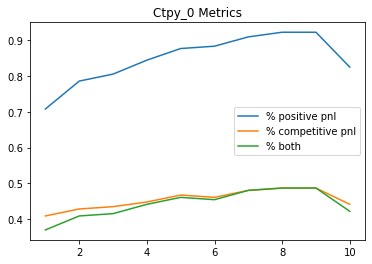

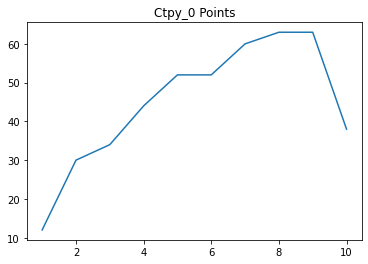

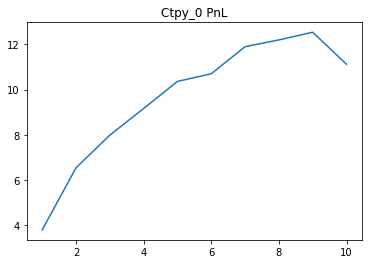

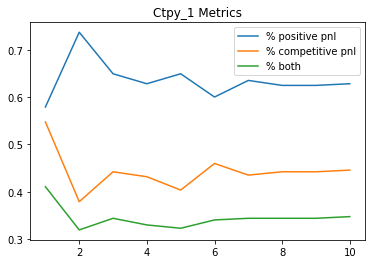

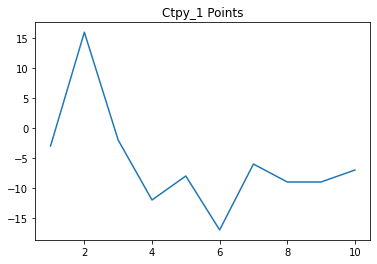

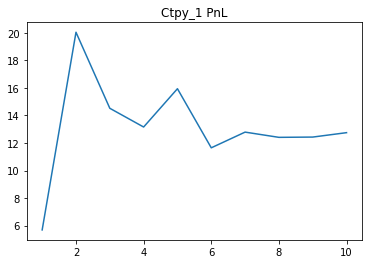

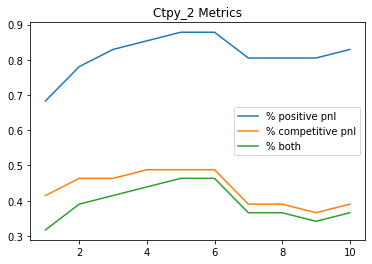

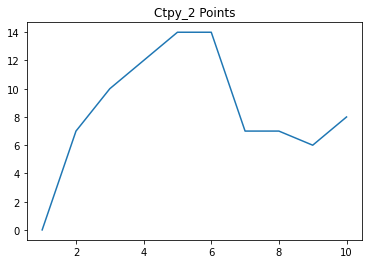

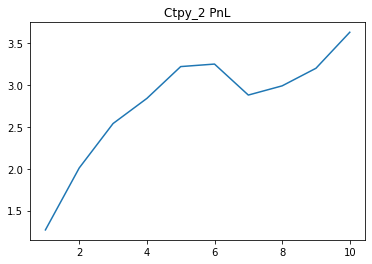

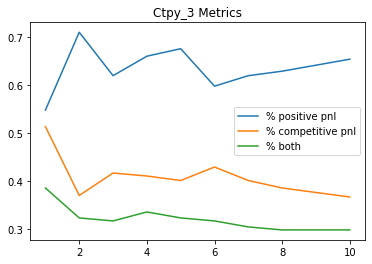

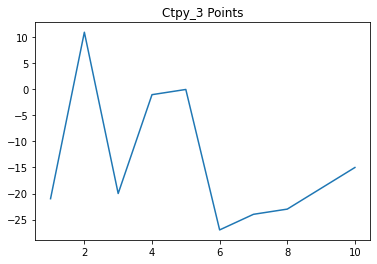

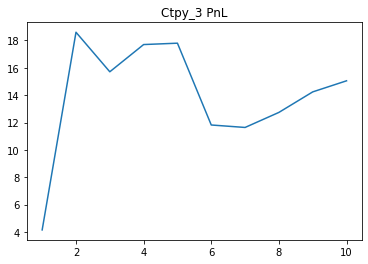

In [88]:
plot_graphs = True
for counterparty in ['Ctpy_0', 'Ctpy_1', 'Ctpy_2', 'Ctpy_3']:
    test = oos_test.query("Counterparty == @counterparty").copy()
    test_quotes = test.loc[:, 'QuotedPrice']
    test_nextmp = test.loc[:, 'NextMidPrice']
    test = add_features_rf(test)
    pnl_arr = []
    pos_pnl_arr = []
    comp_arr = []
    both_arr = []
    points_arr = []
    lambdas = np.arange(1, 11, 1)
    for lam in lambdas:
        counterparty_lambdas[counterparty] = lam
        b_quotes = rfq_model1(test, counterparty_lambdas)[0]
        
        positive_pnl, competitive, both, points, pnl = test_rfq_quotes(test, b_quotes, 
                                                                       test_quotes, test_nextmp)
        pos_pnl_arr.append(positive_pnl)
        comp_arr.append(competitive)
        both_arr.append(both)
        points_arr.append(points)
        pnl_arr.append(pnl)
    
    if plot_graphs:
        plt.plot(lambdas, np.array(pos_pnl_arr)/len(test), label='% positive pnl')
        plt.plot(lambdas, np.array(comp_arr)/len(test), label='% competitive pnl')
        plt.plot(lambdas, np.array(both_arr)/len(test), label='% both')
        plt.title(counterparty + ' Metrics')
        plt.legend()
        plt.show()
        plt.plot(lambdas, points_arr, label='Points')
        plt.title(counterparty + ' Points')
        plt.show()
        plt.plot(lambdas, pnl_arr, label='PnL')
        plt.title(counterparty + ' PnL')
        plt.show()
    
    optimum_lambda = lambdas[np.argmax(np.array(points_arr)*np.array(pnl_arr))]
    optimum_counterparty_lambdas[counterparty] = optimum_lambda

In [89]:
optimum_counterparty_lambdas

{'Ctpy_0': 9, 'Ctpy_1': 2, 'Ctpy_2': 6, 'Ctpy_3': 2}

## Testing

In [95]:
test = oos_test.copy()
test = add_features_rf(test)
model1_oos_quotes, model1_oos_pwin, model1_oos_ppos = rfq_model1(test, optimum_counterparty_lambdas)

In [96]:
hidden = hidden_test.copy()
hidden = add_features_rf(hidden, nextmidp=False)
model1_hidden_quotes, model1_hidden_pwin, model1_hidden_ppos = rfq_model1(hidden, optimum_counterparty_lambdas, nextmidp=False)

In [93]:
test_quotes = oos_test.loc[:, 'QuotedPrice']
test_nextmp = oos_test.loc[:, 'NextMidPrice']
hidden_quotes = hidden_test_quotes.reset_index().loc[:, 'QuotedPrice']
hidden_nextmp = hidden_test_nextmp.reset_index().loc[:, 'NextMidPrice']

In [98]:
print('Model 1: OOS Test Data')
test_rfq_quotes(test,model1_oos_quotes,test_quotes, test_nextmp, print_=True)

Model 1: OOS Test Data
Total Trades = 801
Positive pnl quotes = 616
Competitive quotes = 322
Trades won = 289
Points = 104
PnL =  54.42999999998965




(616, 322, 289, 104, 54.42999999998965)

In [99]:
print('Model 1: Hidden Test Data')
test_rfq_quotes(hidden, model1_hidden_quotes, hidden_quotes, hidden_nextmp, print_=True)

Model 1: Hidden Test Data
Total Trades = 200
Positive pnl quotes = 151
Competitive quotes = 151
Trades won = 151
Points = 102
PnL =  12.149999999984274




(151, 151, 151, 102, 12.149999999984274)

### Competition

In [100]:
comp = competition.copy()
comp = add_features_rf(comp, nextmidp=False)
comp_quotes, comp_pwin, comp_ppos = rfq_model1(comp, optimum_counterparty_lambdas, nextmidp=False, print_=True)
competition['QuotedPrice'] = comp_quotes

Trade is for Bid side
Profit if Quote Price is below Next Mid Price
Using model to generate midprice forecast
Current mid price is: 82.55
Predicted next mid price is: 82.52
Best Quote price is: 82.43
Trade is for Bid side
Profit if Quote Price is below Next Mid Price
Current midprice is estimate of next midprice
Current mid price is: 110.32
Predicted next mid price is: 110.32
Best Quote price is: 110.24
Trade is for Offer side
Profit if Quote Price is above Next Mid Price
Using model to generate midprice forecast
Current mid price is: 126.83
Predicted next mid price is: 127.04
Best Quote price is: 127.12
Trade is for Bid side
Profit if Quote Price is below Next Mid Price
Current midprice is estimate of next midprice
Current mid price is: 82.28
Predicted next mid price is: 82.28
Best Quote price is: 82.19
Trade is for Offer side
Profit if Quote Price is above Next Mid Price
Current midprice is estimate of next midprice
Current mid price is: 109.99
Predicted next mid price is: 109.99
Bes

In [101]:
competition

,Time,Bond,Side,Notional,Counterparty,MidPrice,QuotedPrice,Competitors
0,31000,Bond_0,Bid,1000,Ctpy_0,82.55,82.43,3
1,31001,Bond_2,Bid,1000,Ctpy_3,110.32,110.24,4
2,31004,Bond_1,Offer,300000,Ctpy_0,126.83,127.12,2
3,31008,Bond_0,Bid,1000,Ctpy_1,82.28,82.19,1
4,31009,Bond_2,Offer,1000,Ctpy_1,109.99,110.06,2
